In [1]:
%matplotlib inline


# Gesture recognition with spatiotemporal models

A tutorial on designing efficient models for streaming video tasks.


## 1. Introduction: why spatiotemporal models?

Recognizing gestures from video is a challenging task that requires understanding not just
individual frames but how those frames evolve over time. Traditional 2D convolutional neural
networks (CNNs) are limited here — they analyze only spatial features and discard temporal
continuity. 3D CNNs, while well suited to the task, are on the other hand computationally heavy.

To tackle this, we turn to lightweight spatiotemporal models, specifically designed to process
patterns in both space (image structure) and time (motion, rhythm). These models are essential
for tasks like:

* Gesture classification
* Online eye-tracking
* Real-time activity detection in video streams

At the heart of these models lies a simple idea: decoupling spatial and temporal analysis,
enables efficient, real-time detection — even on resource-constrained devices.



## 2. Spatiotemporal blocks: the core concept

Rather than using full, computationally expensive 3D convolutions, our spatiotemporal blocks break
the operation into two parts, a:

1. Temporal convolution, which focuses on changes over time for each spatial pixel (e.g. motion).
2. Spatial convolution, which looks at image structure in each frame (e.g. shape, position).

The figures below highlights the difference between a full 3D convolution kernel versus our
spatiotemporal convolution (a.k.a. TENN in the figure below).

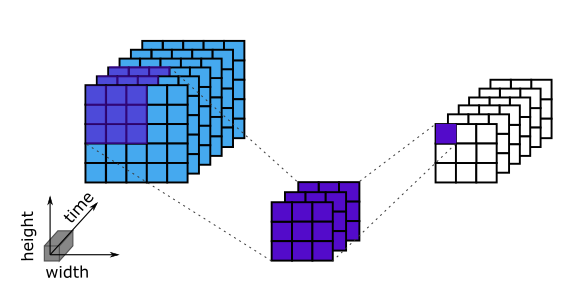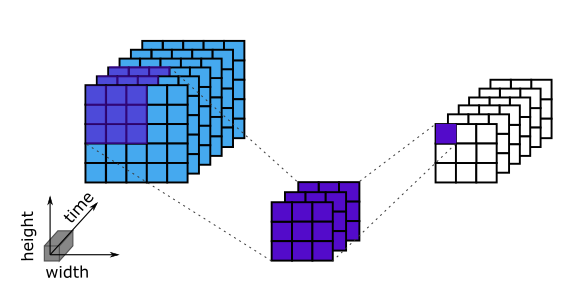


This factorized approach reduces compute requirements. In fact, this design proved effective in
very different domains: it was applied to gesture videos as well as event-based eye tracking
(see tutorial).



### 2.1. Making it efficient using depthwise separable convolutions

To further reduce the computational load of the blocks, we can make them separable, just like
depthwise separable convolutions replace full convolutions, reducing computation with minimal
accuracy loss, our decomposed temporal-spatial convolutions can also be made separable using
an approach inspired by the [MobileNet paper](https://arxiv.org/abs/1704.04861)_. Each layer
from the spatiotemporal block is decomposed into 2: the temporal convolution is
transformed into a depthwise temporal convolutional layer followed by a pointwise convolutional
layer (see figure above), the same is done for the spatial convolution.

##### Note:
  The design of these spatiotemporal blocks is similar to R(2+1)D blocks, except we place the
  temporal layer first. Doing this preserves the temporal richness of the raw input — a critical
  decision that avoids "smearing" out important movement cues. Moreover, notice that our temporal
  layers do not have a stride (compared to R(2+1)D layers).

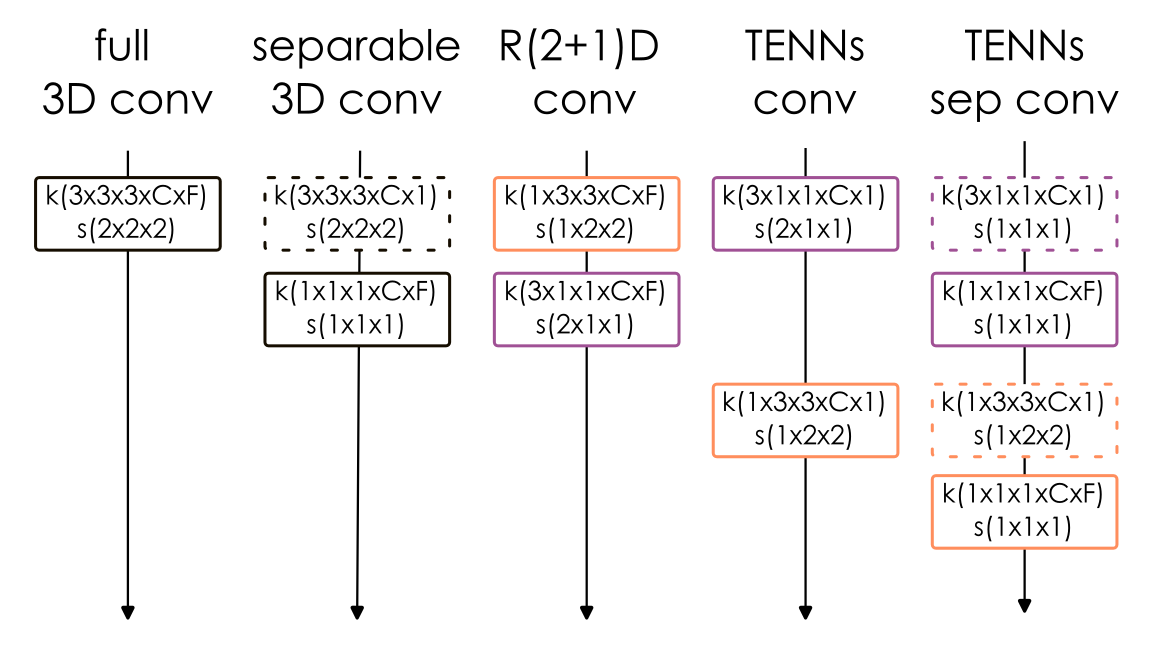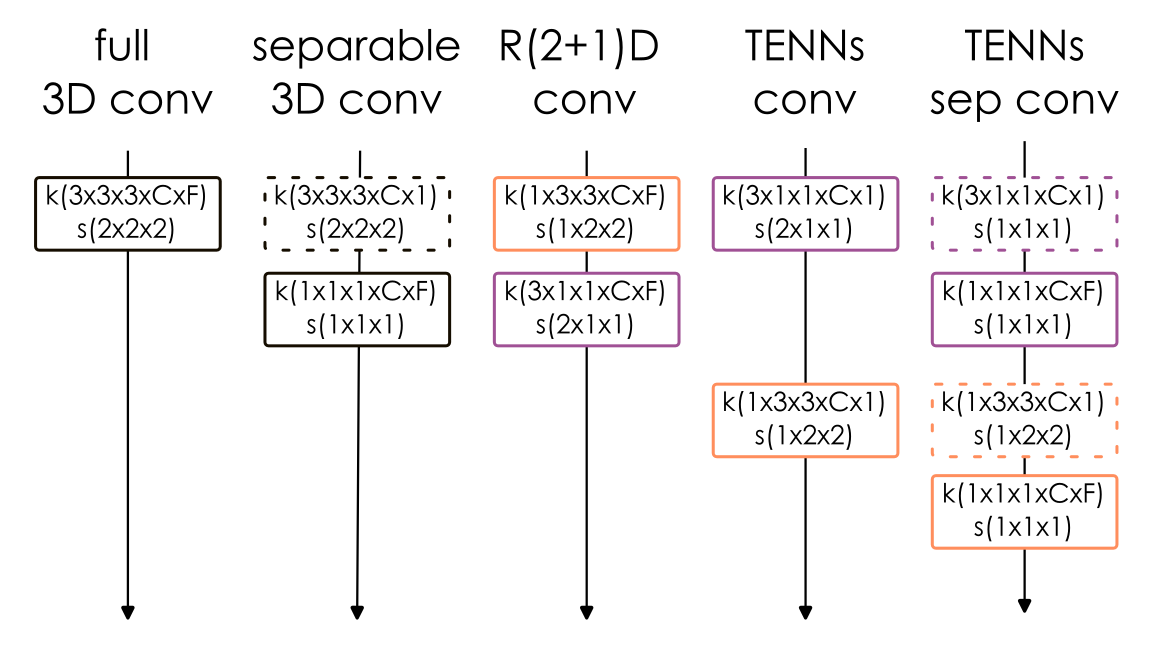
   
   In the above figure, The Kernel dimensions and strides for various types of 3D convolutions. Dotted lines show depthwise
   convolutions. Full lines show full convolutions. Orange outlines are for spatial 3D convs and
   purple ones for temporal convolutions.

A spatiotemporal block can be easily built using the predefined spatiotemporal
blocks from Akida models available through the [akida_models.layer_blocks.spatiotemporal_block](../../api_reference/akida_models_apis.html#akida_models.layer_blocks.spatiotemporal_block)_
API.



## 3. Building the model: from blocks to network

Our gesture recognition model stacks 5 spatiotemporal blocks, forming a shallow yet expressive
network. This depth allows the model to:

- Gradually capture complex temporal patterns (e.g. "swipe up", "rotate clockwise")
- Downsample spatially to control compute load
- Preserve fine-grained timing via non-strided temporal layers
- Easily train without skip connections



In [2]:
input_shape = (100, 100, 3)
sampling_frequency = 16
input_scaling = (127.5, -1.0)
n_classes = 27

from akida_models.tenn_spatiotemporal import tenn_spatiotemporal_jester
model = tenn_spatiotemporal_jester(input_shape=(sampling_frequency,) + input_shape,
                                   input_scaling=input_scaling, n_classes=n_classes)
model.summary()

2025-07-31 14:41:56.908403: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 14:41:56.929325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 14:41:56.929342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 14:41:56.929917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 14:41:56.933474: I tensorflow/core/platform/cpu_feature_guar

Model: "jester_video"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 16, 100, 100, 3   0         
                             )]                                  
                                                                 
 input_conv (Conv3D)         (None, 16, 50, 50, 8)     216       
                                                                 
 input_conv/BN (BatchNormal  (None, 16, 50, 50, 8)     32        
 ization)                                                        
                                                                 
 input_conv/relu (ReLU)      (None, 16, 50, 50, 8)     0         
                                                                 
 activity_regularization (A  (None, 16, 50, 50, 8)     0         
 ctivityRegularization)                                          
                                                      

### 3.1 Preserving temporal information
As you can see from the summary, the model ends with an 3D average pooling applied only
on the spatial dimensions. This ensures that the model can make predictions after the
first input frame, preserving fine-grained temporal dynamics and bufferized inference
(see section 6.)



## 4. Gesture classification in videos

In this tutorial, we use the [Jester dataset](https://www.qualcomm.com/developer/software/jester-dataset)_,
a gesture recognition dataset specifically designed to include movements targeted at human/machine
interactions. To do well on the task, information needs to be aggregated across time to accurately
separate complex gestures such as clockwise or counterclowise hand turning.

The data is available to download in the form of zip files from the
[qualcomm website](https://www.qualcomm.com/developer/software/jester-dataset)_ along with
[download instructions](https://www.qualcomm.com/content/dam/qcomm-martech/dm-assets/documents/qualcomm-ai-research-jester-download-instructions-v2.pdf)_.



### 4.1 Dataset description
In the jester dataset, each sample is a short video clip (about 3 seconds) recorded through a
webcam with fixed resolution of 100 pixels in height and a frame rate of 12 FPS. There are in
total 148,092 videos of 27 different complex gestures covering examples such as "Zooming Out With
2 fingers", "Rolling Hand Forward", "Shaking Hand", "Stop Sign", "Swiping Left", etc..., also
including a "no gesture" and a "other movements" classes.

It is a rich and varied dataset with over 1300 different actors performing the gestures.
The dataset has determined splits for training, validation and testing with the ratio of
80%/10%/10%.



### 4.2 Data preprocessing
To train the model effectively, we apply minimal preprocessing:

- Extract a fixed number of frames (here 16 frames) per sample
- Use strided sampling (stride=2) to reduce redundancy and speed up training
- Resize the input to a fixed input size (100, 100)
- Normalize inputs (between -1 and 1)
- Optionally apply an affine transform for training data (ie. randomly and independently apply
  translation, scaling, shearing and rotation to each video).

The dataset is too large to load completely in a tutorial. If you download the dataset
at the links mentioned above, you can load and preprocess it using the get_data API
available under akida_models.tenn_spatiotemporal.jester_train.

Alternatively, the first few validation samples have been set aside and
can be loaded here to demonstration purposes.



In [3]:
batch_size = 8

# Download and load validation subset from Brainchip data server
import os
from akida_models import fetch_file
from akida_models.tenn_spatiotemporal.jester_train import get_data

data_path = fetch_file(
    fname="jester_subset.tar.gz",
    origin="https://data.brainchip.com/dataset-mirror/jester/jester_subset.tar.gz",
    cache_subdir=os.path.join("datasets", "jester"), extract=True)
data_dir = os.path.join(os.path.dirname(data_path), "jester_subset")
val_dataset, val_steps = get_data("val", data_dir, sampling_frequency, input_shape[:2], batch_size)

# Decode numeric labels into human readable ones: contains all string names for classes
# available in the dataset
import csv
with open(os.path.join(data_dir, "jester-v1-labels.csv")) as csvfile:
    class_names = [row[0] for row in csv.reader(csvfile)]

In [4]:
print(f"classes available are : {class_names}")

classes available are : ['Swiping Left', 'Swiping Right', 'Swiping Down', 'Swiping Up', 'Pushing Hand Away', 'Pulling Hand In', 'Sliding Two Fingers Left', 'Sliding Two Fingers Right', 'Sliding Two Fingers Down', 'Sliding Two Fingers Up', 'Pushing Two Fingers Away', 'Pulling Two Fingers In', 'Rolling Hand Forward', 'Rolling Hand Backward', 'Turning Hand Clockwise', 'Turning Hand Counterclockwise', 'Zooming In With Full Hand', 'Zooming Out With Full Hand', 'Zooming In With Two Fingers', 'Zooming Out With Two Fingers', 'Thumb Up', 'Thumb Down', 'Shaking Hand', 'Stop Sign', 'Drumming Fingers', 'No gesture', 'Doing other things']


## 5. Training and evaluating the model

The model is trained using standard techniques: Adam optimizer, cosine LR scheduler and
Categorical Cross-Entropy. We modify the categorical crossentropy slightly to make it "temporal":
the target class (y-label) is replicated at each time point, thus forcing the model to correctly
classify each video frame.

Since the training requires a few GPU hours to complete, we will load a pre-trained model for
inference. Pre-trained models are available either in floating point or quantized version.
First, we'll look at the floating point model, available using the following apis. The evaluation
tool is also available to rapidly test the performance on the validation dataset.

.. Note: the accuracy here is low because it is computed weighing each time point equally, i.e.
         the first frame when the event has not started contributes as much to the predicted label
         as a frame with an actual movement in it. The validation accuracy will dramatically
         improve once we allow the model to weigh its output in time (see section below).



In [5]:
from akida_models.model_io import get_model_path, load_model
from akida_models.utils import fetch_file
from akida_models.tenn_spatiotemporal.jester_train import compile_model

model_name_v2 = "tenn_spatiotemporal_jester.h5"
file_hash_v2 = "fca52a23152f7c56be1f0db59844a5babb443aaf55babed7669df35b516b8204"
model_path, model_name, file_hash = get_model_path("tenn_spatiotemporal",
                                                   model_name_v2=model_name_v2,
                                                   file_hash_v2=file_hash_v2)
model_path = fetch_file(model_path,
                        fname=model_name,
                        file_hash=file_hash,
                        cache_subdir='models')

model = load_model(model_path)
compile_model(model, 3e-4, val_steps, 1, sampling_frequency)

In [6]:
hist = model.evaluate(val_dataset)
print(hist)

2025-07-31 14:42:01.017568: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb7340a6f20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-07-31 14:42:01.017600: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1753998121.025847 1409239 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-07-31 14:42:01.025989: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


68/68 [==============================] - 18s 248ms/step - loss: 1.4964 - temporal_accuracy: 0.7115
[1.4963833093643188, 0.711529552936554]


## 6. Streaming inference: making real-time predictions

Once trained, these models can be deployed in online inference mode, making predictions
frame-by-frame. This works thanks to:

- **causal convolutions**, which ensure that predictions at time *t* use only past and current
  frames, not future ones by adding (left-sided) zero-padding. This is critical for streaming
  inference where latency matters: we want to be able to make predictions immediately. Our
  causal temporal layers don't rely on future frames and start making predictions after the
  first frame is received.
- **not using a temporal stride**: our model purposefully preserves time information and thus
  is able to make a classification guess after each incoming frame.

These choices also allow us to configure the spatio-temporal layer in a efficient way using
FIFO buffers during inference.



### 6.1 FIFO buffering

During inference, each temporal layer is replaced with a bufferized 2D convolution: i.e. a
Conv2D with an input buffer the size of its kernel (initialized with zeros), handling the
streaming input features. Spatial convolutions that have a temporal kernel size of 1 can be
seamlessly transformed into 2D convolutions too.

.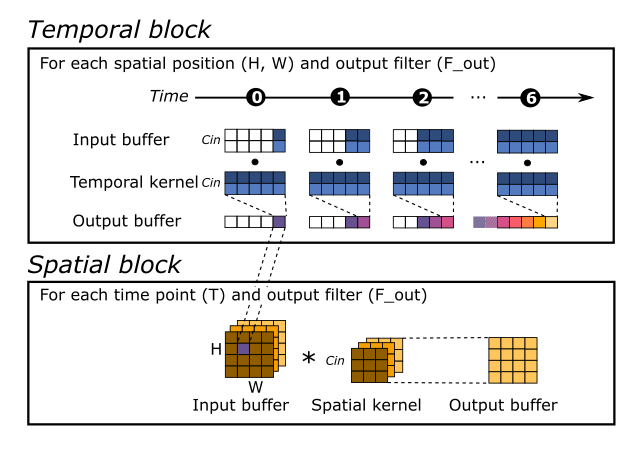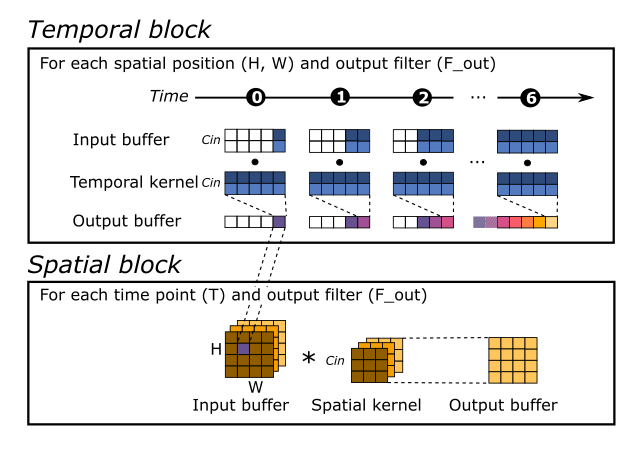

At its core, a convolution (whether 2D or 3D) involves sliding a small filter (also called
a kernel) over the input data and computing a dot product between the filter and a small
segment (or window) of the input at each step.

To make this process more efficient, we can use a FIFO (First In, First Out) buffer to
automatically manage the sliding window. Here's how it works:

- The input buffer holds the most recent values from the input signal (top row on the figure
  above).
- The size of this buffer is equal to the size of the temporal kernel.
- After each new incoming values, we perform a dot product between the buffer contents and the
  kernel to produce one output value.
- Every time a new input value arrives, it's added to the buffer, and the oldest value is
  removed.

This works seamlessly in causal convolutional networks, where the output at any time step only
depends on the current and past input values—not future ones. Because of this causality, the
buffer never needs to "wait" for future input: it can compute the output as soon as the first
frame comes in.

**The result?**: Real-time gesture classification, running continuously, with predictions
ready after every frame.

**How to?** : Akida models provides a simple and easy to use API that transforms compatible
spatiotemporal blocks into their equivalent bufferized version found in
[akida_models.tenn_spatiotemporal.convert_to_buffer](../../api_reference/akida_models_apis.html#akida_models.tenn_spatiotemporal.convert_to_buffer)_

##### Note:

  - After conversion, the 3D Convolution layers are transformed into custom
    [BufferTempConv](../../api_reference/akida_models_apis.html#akida_models.tenn_spatiotemporal.convert_to_buffer)_
    layers.
  - As opposed to training where the whole 16 frames samples is passed to the model, the inference
    model requires samples to be passed one by one.



In [7]:
from akida_models.tenn_spatiotemporal.convert_spatiotemporal import convert_to_buffer
model = convert_to_buffer(model)
model.summary()

Model: "jester_video"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 100, 3)]     0         
                                                                 
 input_conv (Conv2D)         (None, 50, 50, 8)         216       
                                                                 
 input_conv/BN (BatchNormal  (None, 50, 50, 8)         32        
 ization)                                                        
                                                                 
 input_conv/relu (ReLU)      (None, 50, 50, 8)         0         
                                                                 
 convt_full_1_0 (BufferTemp  (None, 50, 50, 20)        820       
 Conv)                                                           
                                                                 
 convt_full_1_0/BN (BatchNo  (None, 50, 50, 20)       

The models then can be evaluated on the data using the helper available that passes
data frame by frame to the model, accumulating the model's responses



In [8]:
from akida_models.tenn_spatiotemporal.jester_train import evaluate_bufferized_model
evaluate_bufferized_model(model, val_dataset, val_steps // batch_size, in_akida=False)

 29%|█████████████████████████████████████████████████████████▋                                                                                                                                          | 68/231 [00:10<00:24,  6.52it/s]

Accuracy:  95.01%


### 6.2 Weighing information

The performance of the buffered model is improved because we use a smoothing mecanism on the
model's output:

- at time *t*, the model's outputs is softmaxed
- the softmaxed values from time *t-1* are decayed (using a decay_factor of 0.8)
- the two are added

This is done across all frames available in the video.
The predicted class is only computed once all the frames have been seen by the model for the
benchmark, but it is possible for the model to predict the video's class after each new frame.
Section 7 below shows an example of this.



Because of this buffering and how the model was trained to output a prediction after each time
step, we can effectively visualize the response of the model in time.
This part of the tutorial is heavily inspired from the tensorflow tutorial on streaming
recognition of gestures based on the [movinet models](https://www.tensorflow.org/hub/tutorials/movinet)_.

We pass the data through the trained model frame by frame and collect the predicted classes,
applying a softmax on the output of the model.
To make the prediction more robust, at each time step we decay the old predictions by a
decay_factor so that they contribute less and less to the final predicted class.
The decay_factor is an hyperparameter that you can play with. In practice, it slightly improves
performance by smoothing the prediction in time and reducing the impact of earlier frames to
the final prediction.

The video below shows one sample along with the probabilities of the top 5 predictions from
our bufferized spatiotemporal model at each time point.


<img src="streaming_preds.gif" width="600" />


## 8. Quantizing the model and convertion to akida
Once bufferized, the model can be easily quantized with no cost in accuracy. It can then be easily
be deployed on hardware for online gesture recognition using the convert method from the cnn2snn
package.



In [9]:
import numpy as np
# Get the calibration data for accurate quantization: these are a subset from the training data.
samples = fetch_file(
    fname="jester_video_bs100.npz",
    origin="https://data.brainchip.com/dataset-mirror/samples/jester_video/jester_video_bs100.npz",
    cache_subdir=os.path.join("datasets", "jester"), extract=False)
samples = os.path.join(os.path.dirname(data_path), "jester_video_bs100.npz")
data = np.load(samples)
samples_arr = np.concatenate([data[item] for item in data.files])
num_samples = len(samples_arr)

In [10]:
from quantizeml.layers import QuantizationParams, reset_buffers
from quantizeml.models import quantize

# Define the quantization parameters and quantize the model
qparams = QuantizationParams(activation_bits=8,
                             per_tensor_activations=True,
                             weight_bits=8,
                             input_weight_bits=8,
                             input_dtype="uint8")
model_quantized = quantize(model, qparams=qparams, samples=samples_arr,
                           num_samples=num_samples, batch_size=100, epochs=1)

16/16 [==============================] - 1s 36ms/step


In [11]:
# Evaluate the quantized model
evaluate_bufferized_model(model_quantized, val_dataset, val_steps // batch_size, in_akida=False)
reset_buffers(model_quantized)

 29%|█████████████████████████████████████████████████████████▋                                                                                                                                          | 68/231 [00:37<01:30,  1.80it/s]

Accuracy:  94.64%


In [12]:
# Convert to akida
from cnn2snn import convert
akida_model = convert(model_quantized)
akida_model.summary()

2025-07-31 14:43:21.774751: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: jester_video/convt_full_1_0/assert_less_equal/Assert/AssertGuard/branch_executed/_103


                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[100, 100, 3]  [1, 1, 27]    1          18    
________________________________________________

_________________________________________________________________________
Layer (type)                            Output shape   Kernel shape    

================== SW/input_conv-dequantizer (Software) =================

input_conv (InputConv2D)                [50, 50, 8]    (3, 3, 3, 8)    
_________________________________________________________________________
convt_full_1_0 (BufferTempConv)         [50, 50, 20]   (1, 1, 40, 20)  
_________________________________________________________________________
convs_full_1_0 (Conv2D)                 [25, 25, 40]   (3, 3, 20, 40)  
_________________________________________________________________________
convt_full_2_0 (BufferTempConv)         [25, 25, 80]   (1, 1, 200, 80) 
__________________________

In [13]:
from cnn2snn import set_akida_version, AkidaVersion
import akida

with set_akida_version(AkidaVersion.v2):
    devices = akida.devices()
    if len(devices) > 0:
        print(f'Available devices: {[dev.desc for dev in devices]}')
        device = devices[0]
        print(device.version)
        try:
            akida_model.map(device)
            print(f"Mapping to Akida device {device.desc}.")
            mappedDevice = device.version
        except Exception as e:
            print("Model not compatible with FPGA. Running on CPU.")
            mappedDevice = "CPU"
    else:
        print("No Akida devices found, running on CPU.")
        mappedDevice = "CPU"

Available devices: ['fpga-1691']
BC.A2.001.000
Mapping to Akida device fpga-1691.


### Model Summary After Mapping

In [14]:
akida_model.summary()

                                      Model Summary                                      
_________________________________________________________________________________________
Input shape    Output shape  Sequences  Layers  NPs  Skip DMAs  External Memory (Bytes)
[100, 100, 3]  [1, 1, 27]    1          18      44   5          892080                 
_________________________________________________________________________________________

_________________________
Component (type)  Count
HRC               1    
_________________________
CNP1              23   
_________________________
FNP2              1    
_________________________
FNP3              1    
_________________________
SKIP_DMA_STORE    5    
_________________________
TNP_B             19   
_________________________
SKIP_DMA_LOAD     5    
_________________________

                     External Memory Summary                     
_________________________________________________________________
Layer (type)        

## 9. Final thoughts: generalizing the approach

Spatiotemporal networks are powerful, lightweight, and flexible. Whether you're building
gesture-controlled interfaces or real-time eye-tracking systems, the same design principles
apply:

- Prioritize temporal modeling early in the network
- Use factorized spatiotemporal convolutions for efficiency
- Train with augmentation that preserves causality
- is seamlessly deployed using streaming inference using FIFO buffers



#### Note: Once you’ve finished running the notebook, ***"Uncomment and run the cell below"*** to release the device and free it up for further experiments.

In [15]:
# import os
# os._exit(00)

#### You can also use this button to reset your kernel

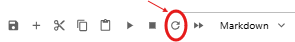